# Home Loan Approval/Denial: Models, part C: Neural Network

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import classification_report
from keras import models, layers, callbacks, losses, metrics

from sklearn import set_config

set_config(display="diagram")

2024-07-30 19:49:37.726109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 19:49:37.726923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 19:49:37.729752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 19:49:37.738570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 19:49:37.753238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
# Local functions
from modeling_preparation import get_X_y, refit_strategy

#### Auxiliary variables

In [4]:
filename_input = "data-hdma-eastbay-2019-2022-processed"

## Loading the processed data

In [5]:
X_train, X_test, y_train, y_test = get_X_y(filename_input, ohe_transform=True)

for col in list(X_train.select_dtypes(include=object).columns):
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

## Neural Network

In [6]:
model = models.Sequential(
    [
        layers.Dense(100, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer="adam",
    loss=losses.BinaryFocalCrossentropy(
        # apply_class_balancing=False,
        alpha=0.35,
        name="binary_focal_crossentropy",
    ),
    metrics=["acc", "precision", "recall", metrics.AUC(curve="PR")],
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    restore_best_weights=True,
    start_from_epoch=5,
    patience=15,
)
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.7375 - auc: 0.8371 - loss: 0.1354 - precision: 0.7624 - recall: 0.8715 - val_acc: 0.7918 - val_auc: 0.8851 - val_loss: 0.1167 - val_precision: 0.7845 - val_recall: 0.9424
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7849 - auc: 0.8769 - loss: 0.1198 - precision: 0.7849 - recall: 0.9268 - val_acc: 0.7950 - val_auc: 0.8890 - val_loss: 0.1153 - val_precision: 0.7879 - val_recall: 0.9421
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7923 - auc: 0.8826 - loss: 0.1174 - precision: 0.7894 - recall: 0.9338 - val_acc: 0.7968 - val_auc: 0.8903 - val_loss: 0.1148 - val_precision: 0.7870 - val_recall: 0.9476
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7930 - auc: 0.8846 - loss: 0.1169 - precision: 0.7898 - recall: 0.9339 - val_acc: 0.7977 - val_auc: 0.8911 - val_loss: 0.1143 - val_precision: 0.7938 - val_recall: 0.9355
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7921 -

In [8]:
model.get_metrics_result()

{'acc': 0.8019793033599854,
 'auc': 0.8955217003822327,
 'loss': 0.11244133859872818,
 'precision': 0.7974711060523987,
 'recall': 0.9369916915893555}

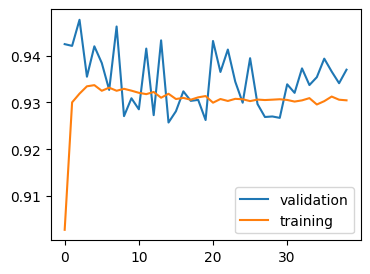

In [9]:
plt.figure(figsize=(4, 3))
plt.plot(history.history["val_recall"], label="validation")
plt.plot(history.history["recall"], label="training")
plt.legend()
plt.show()

In [10]:
predictions = np.where(model.predict(X_test, batch_size=512) > 0.5, 1, 0)
print(classification_report(y_test, predictions))

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.55      0.65     22501
           1       0.80      0.93      0.86     43280

    accuracy                           0.80     65781
   macro avg       0.81      0.74      0.76     65781
weighted avg       0.80      0.80      0.79     65781

